# Problem Domain

Persaingan yang semakin ketat di industri ritel mendorong toko-toko untuk memperdalam pemahaman terhadap pelanggan mereka. Dengan pemahaman yang baik tentang demografi pelanggan, perilaku belanja, dan interaksi mereka dengan toko, toko dapat meningkatkan strategi pemasaran dan promosi mereka. Analisis demografi seperti usia, pendidikan, dan status pernikahan dapat membantu dalam mengidentifikasi pola pembelian yang relevan. Informasi tentang perilaku belanja seperti kemungkinan pembelian, efektivitas program promosi, dan segmen pelanggan potensial juga dapat dieksplorasi dari dataset yang telah diberikan. Selain itu, dataset ini juga dapat digunakan untuk meningkatkan layanan pelanggan dan membangun hubungan yang lebih kuat dengan pelanggan, yang pada akhirnya dapat meningkatkan retensi pelanggan dan keuntungan toko. Maka, mencari program promosi yang efektif bagi individu-individu yang spesifik perlu dikulas dengan baik.

# Importing Libraries

In [379]:
%pip install category_encoders

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [380]:
# Pake yang ini
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
import missingno as mno
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Data Extraction

In [381]:
TRAIN_FEATURE_PATH = r'../../Datasets/train_features.csv'
TRAIN_LABEL_PATH = r'../../Datasets/train_labels.csv'
TEST_PATH = r'../../Datasets/test_features.csv'
SAMPLE_SUBMISSION_PATH = r"../../Datasets/submission_format.csv"

In [382]:
train_feature_dat = pd.read_csv(TRAIN_FEATURE_PATH)
train_label_dat = pd.read_csv(TRAIN_LABEL_PATH)
test_dat = pd.read_csv(TEST_PATH)

In [383]:
train_feature_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3817 entries, 0 to 3816
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tahun_kelahiran          3817 non-null   int64  
 1   pendidikan               3628 non-null   object 
 2   status_pernikahan        3605 non-null   object 
 3   pendapatan               3627 non-null   float64
 4   jumlah_anak_balita       3627 non-null   float64
 5   jumlah_anak_remaja       3613 non-null   float64
 6   terakhir_belanja         3645 non-null   float64
 7   belanja_buah             3636 non-null   float64
 8   belanja_daging           3639 non-null   float64
 9   belanja_ikan             3624 non-null   float64
 10  belanja_kue              3603 non-null   float64
 11  pembelian_diskon         3639 non-null   float64
 12  pembelian_web            3652 non-null   float64
 13  pembelian_toko           3648 non-null   float64
 14  keluhan                 

Didapatkan bahwa feature tanggal_menjadi_anggota memiliki lebih dari setengah datanya bernilai Null

In [384]:
train_feature_dat.duplicated().sum()

0

Tidak ada data yang terduplikasi

# Data Prep


In [385]:
# Menggabungkan training features data dan training label data untuk mempermudah proses analisis
train_feature_dat = pd.merge(train_feature_dat, train_label_dat, left_index=True, right_index=True)

# Exploratory Data Analysis

# Univariate

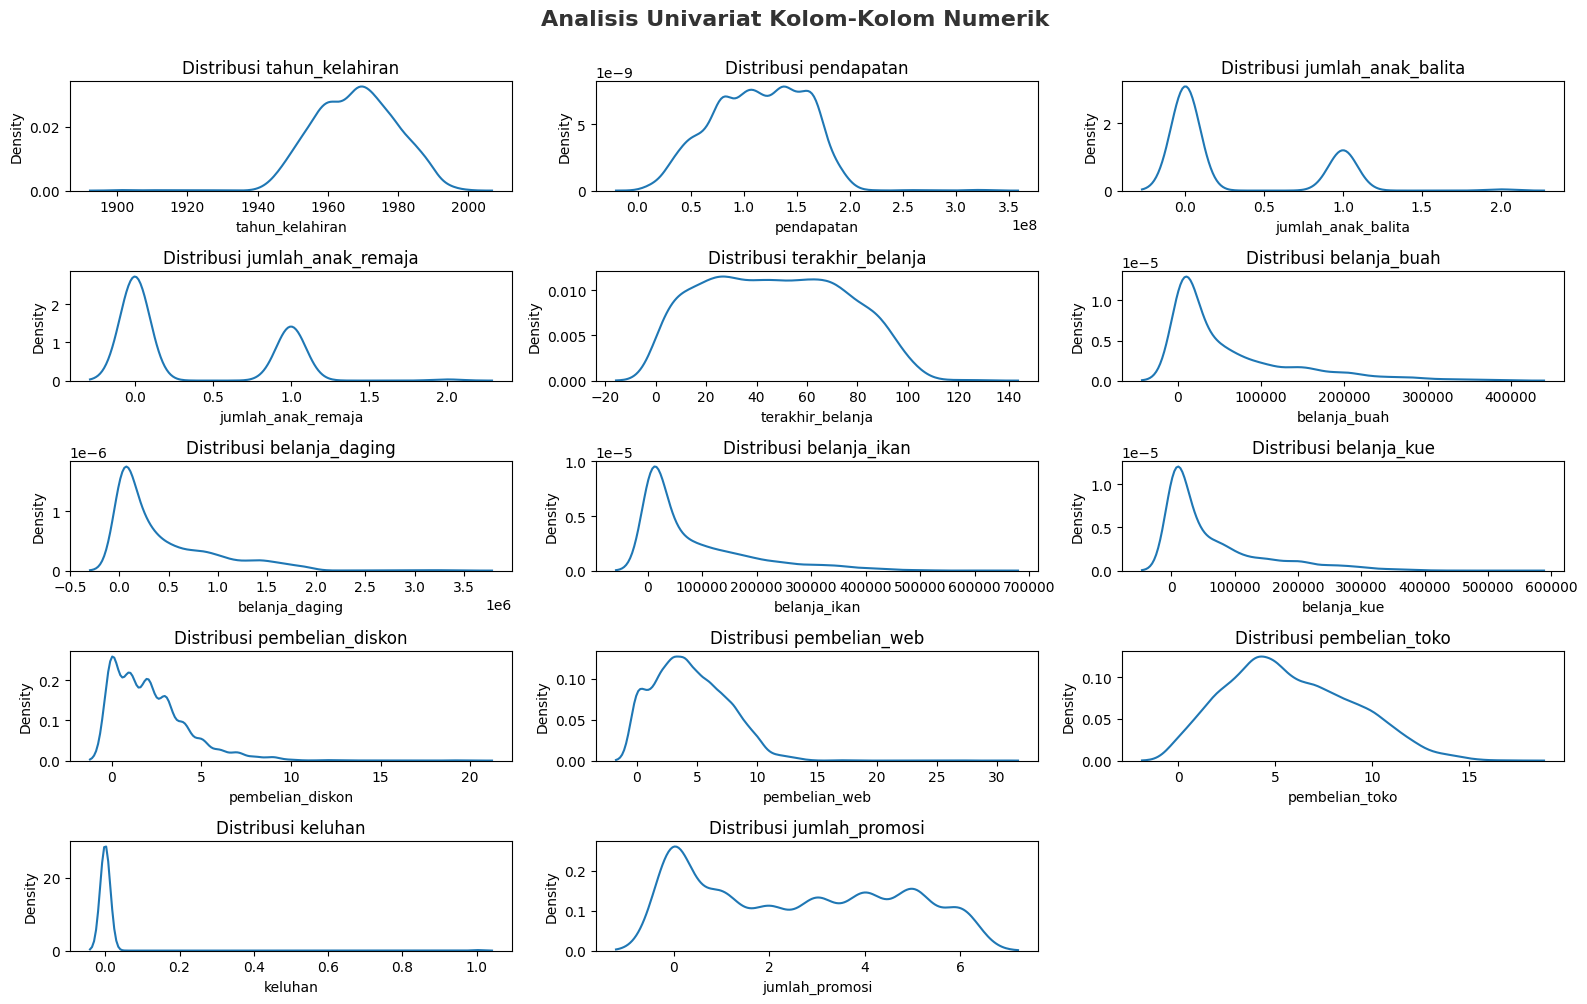

In [386]:
def univariate_analysis(preped_train, height=10):
    """
    Melakukan analisis univariat pada kolom-kolom numerik dalam DataFrame.

    Parameters:
        data (DataFrame): DataFrame yang akan dianalisis.
        tinggi (int, optional): Tinggi gambar subplot dalam inci (default: 10).

    Returns:
        None

    Contoh Penggunaan:
        analisis_univariat(data_viz, tinggi=10)
    """
    # Memfilter DataFrame untuk hanya mengandung kolom-kolom numerik
    numerical_columns = preped_train.select_dtypes(include=['number'])
    
    # Menentukan jumlah baris dan kolom untuk subplot secara dinamis
    num_numerical_cols = len(numerical_columns.columns)
    num_subplot_cols = 3  # Number of columns for subplots
    
    num_subplot_rows = (num_numerical_cols + num_subplot_cols - 1) // num_subplot_cols 
    
    # Membuat subplot
    plt.figure(figsize=(16, height))
    plt.suptitle('Analisis Univariat Kolom-Kolom Numerik', fontsize=16, fontweight='bold', alpha=0.8, y=1.)
    for i, column in enumerate(numerical_columns.columns):
        plt.subplot(num_subplot_rows, num_subplot_cols, i + 1)
        sns.kdeplot(data=numerical_columns[column])
        plt.title(f'Distribusi {column}')
    
    plt.tight_layout()
    plt.show()

univariate_analysis(train_feature_dat, height=10)

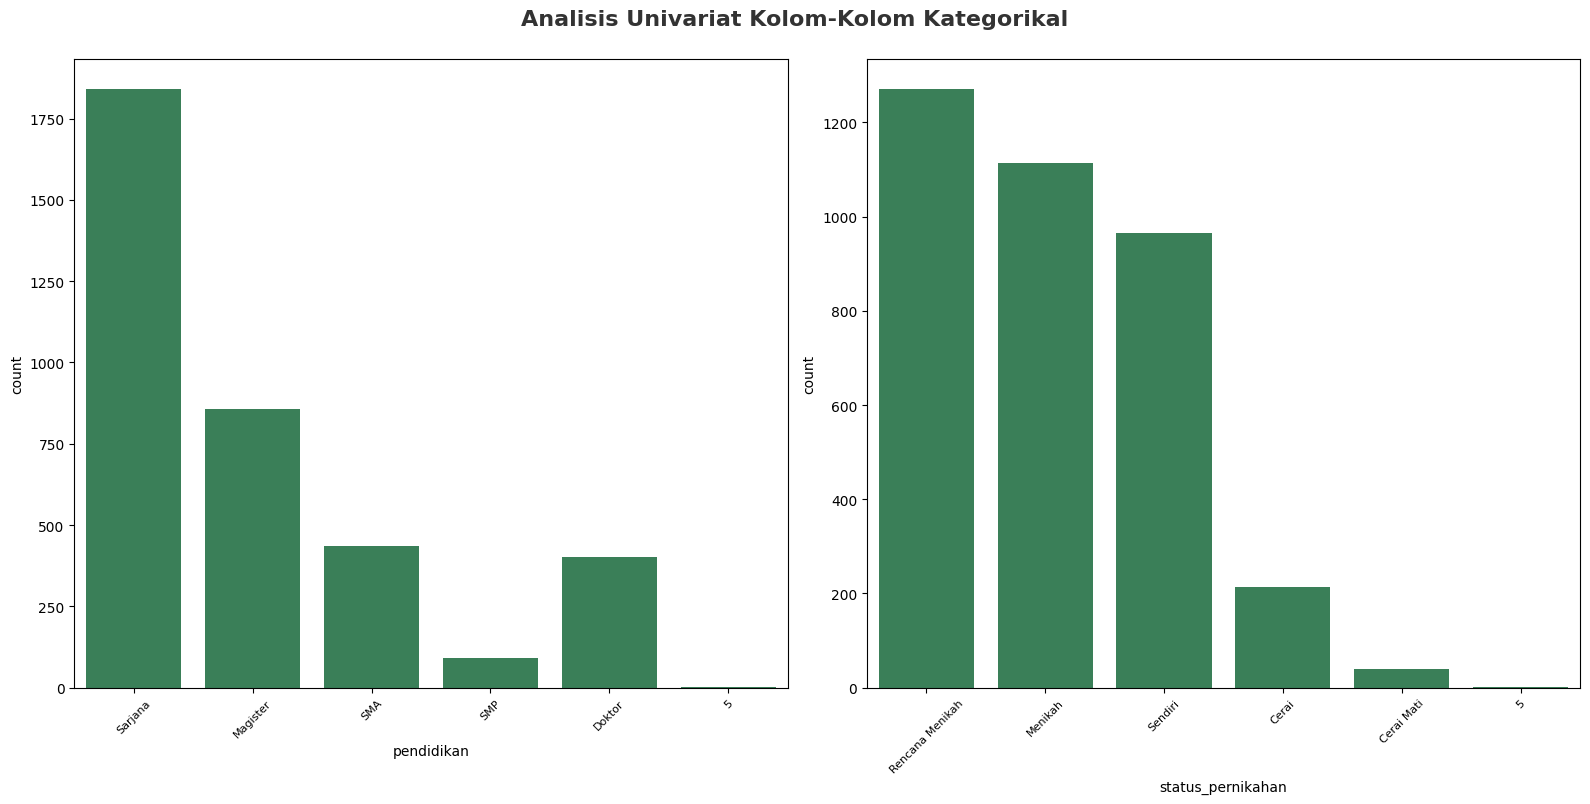

In [387]:
cat_cols = ['pendidikan', 'status_pernikahan']
# Menampilkan analisis univariate untuk kolom kategorikal
plt.figure(figsize=(16, 8))
plt.suptitle('Analisis Univariat Kolom-Kolom Kategorikal', fontsize=16, fontweight='bold', alpha=0.8, y=1.)
num_cat_cols = len(cat_cols)
num_rows = (num_cat_cols + 1) // 2  # Menghitung jumlah baris yang diperlukan untuk 2 kolom
for i in range(0, num_cat_cols):
    plt.subplot(num_rows, 2, i+1)   # Menggunakan 2 kolom
    sns.countplot(x=train_feature_dat[cat_cols[i]], color='seagreen')
    plt.xticks(rotation=45, fontsize=8)  # Memutar label sumbu x sebesar 45 derajat dan mengatur fontsize
    plt.tight_layout()

<Axes: >

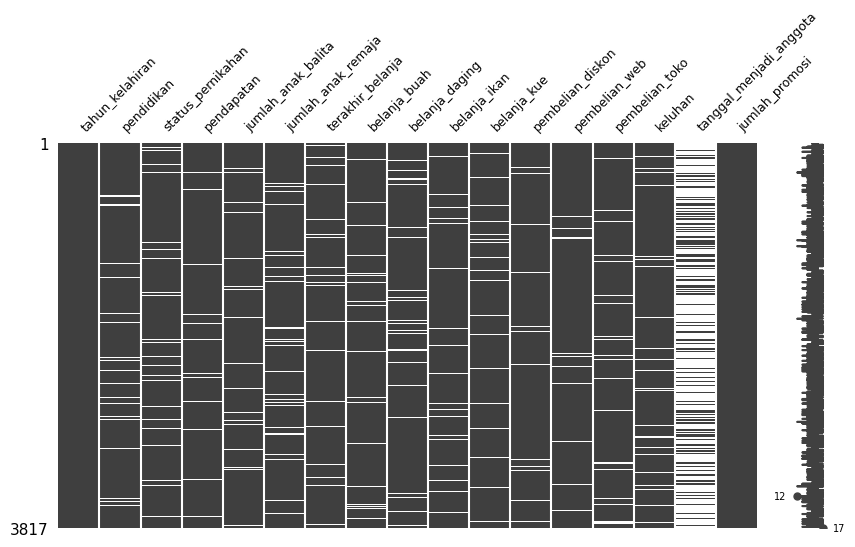

In [388]:
mno.matrix(train_feature_dat, figsize=(10, 5), fontsize=9)

## Bivariate

### Correlation Matrix

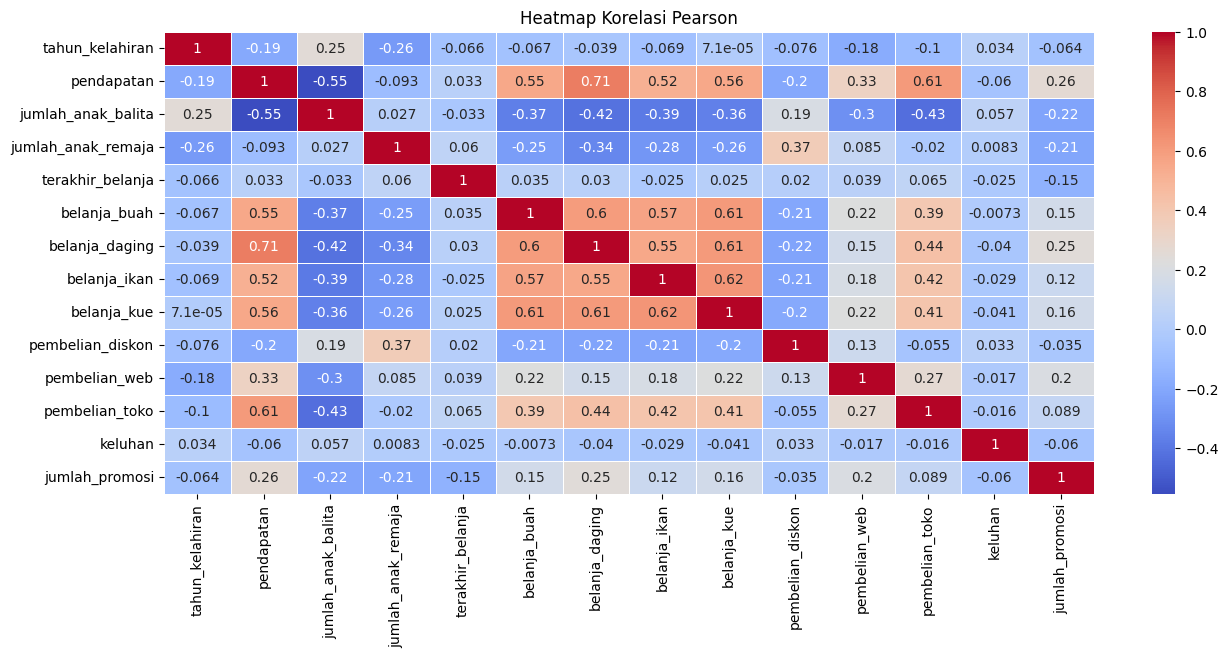

In [389]:
correlation_matrix = train_feature_dat.corr(method='pearson')

# Menggambar heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Korelasi Pearson')
plt.show()

In [393]:
X_feature = train_feature_dat.drop(columns='jumlah_promosi')
y_label = train_feature_dat['jumlah_promosi']

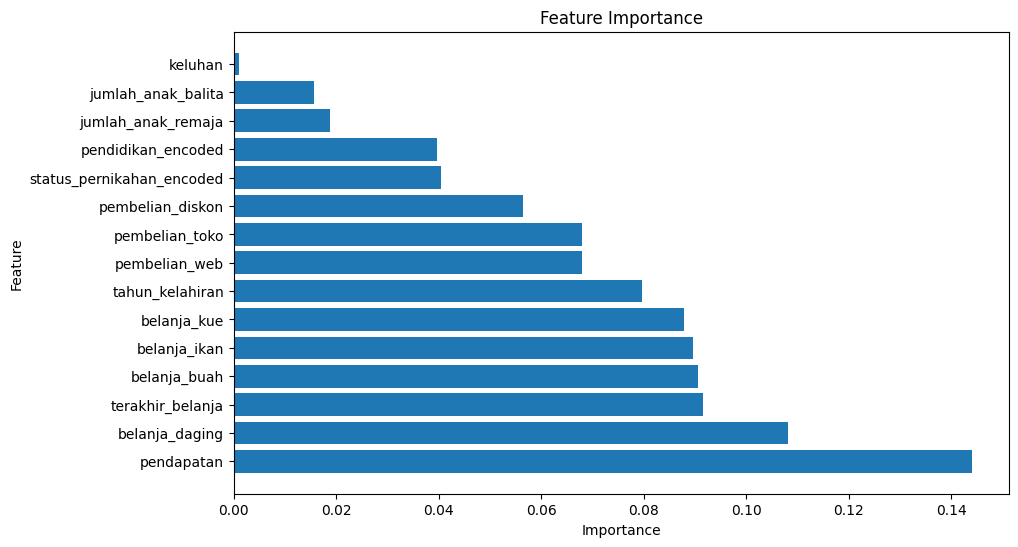

In [394]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_feature, y_label)

feature_importances = model.feature_importances_

importances_df = pd.DataFrame({'Feature': X_feature.columns, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6) ,)
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

## Informasi yang didapat dari EDA

---
- Feature tanggal_menjadi_anggota akan merusak data apabila dibiarkan tetap ada di dataset
- Feature-feature berbau berbelanjaan (belanja_ikan, belanja_daging, dstnya) memiliki distribusi yang hampir sama
- Keluhan, jumlah_anak_balita, dan jumlah_anak_remaja memiliki keterkaitan dengan target feature yang kurang baik.
---

## Dropping Irrelevant features

In [390]:
#drop tanggal_menjadi_anggota
train_feature_dat = train_feature_dat.drop(columns={'tanggal_menjadi_anggota'})
test_dat = test_dat.drop(columns={'tanggal_menjadi_anggota'})

In [395]:
train_feature_dat = train_feature_dat.drop(columns={'keluhan', 'jumlah_anak_balita', 'jumlah_anak_remaja'})
test_dat = test_dat.drop(columns={'keluhan', 'jumlah_anak_balita', 'jumlah_anak_remaja'})


## Encoding

### Label Encoder

In [391]:
label_encoder = LabelEncoder()
train_feature_dat['pendidikan_encoded'] = label_encoder.fit_transform(train_feature_dat['pendidikan'])
train_feature_dat =train_feature_dat.drop(columns='pendidikan')
test_dat['pendidikan_encoded'] = label_encoder.fit_transform(test_dat['pendidikan'])
test_dat =test_dat.drop(columns='pendidikan')

train_feature_dat['status_pernikahan_encoded'] = label_encoder.fit_transform(train_feature_dat['status_pernikahan'])
train_feature_dat =train_feature_dat.drop(columns='status_pernikahan')
test_dat['status_pernikahan_encoded'] = label_encoder.fit_transform(test_dat['status_pernikahan'])
test_dat =test_dat.drop(columns='status_pernikahan')


## Binning

In [396]:
# Define bin edges and labels
bin_edges = [1890, 1920, 1940, 1960, 1980, 2000, 2010]
bin_labels = ['0', '1', '2', '3', '4', '5']

# Perform binning
train_feature_dat['tahun_kelahiran_binned'] = pd.cut(train_feature_dat['tahun_kelahiran'], bins=bin_edges, labels=bin_labels)
train_feature_dat.drop(columns='tahun_kelahiran', inplace=True)
test_dat['tahun_kelahiran_binned'] = pd.cut(test_dat['tahun_kelahiran'], bins=bin_edges, labels=bin_labels)
test_dat.drop(columns='tahun_kelahiran', inplace=True)

## IQR

In [397]:
def handle_outliers_iqr(data):
    # Calculate quartiles
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    # Calculate lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Handle outliers
    # Replace outliers with the upper or lower bound
    data[data < lower_bound] = lower_bound
    data[data > upper_bound] = upper_bound
    
    return data

for column in train_feature_dat.select_dtypes(include=np.number):
    if column != 'jumlah_promosi':
        train_feature_dat[column] = handle_outliers_iqr(train_feature_dat[column])
        test_dat[column] = handle_outliers_iqr(test_dat[column])


## Null Handling

### Simple Imputer

In [398]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Membuat objek SimpleImputer untuk data pelatihan dengan strategi 'median'
imputer_median = SimpleImputer(strategy='median')

# Mengisi nilai yang hilang dalam data pelatihan dengan strategi 'median'
train_feature_dat = pd.DataFrame(imputer_median.fit_transform(train_feature_dat), columns=train_feature_dat.columns)

# Membuat objek SimpleImputer untuk data pengujian dengan strategi 'most_frequent'
imputer_most_frequent = SimpleImputer(strategy='most_frequent')

# Mengambil kolom 'ID' dari df_test
test_dat_id = test_dat['ID']

# Menghapus kolom 'ID' dari df_test
test_dat_features = test_dat.drop('ID', axis=1)

# Melakukan imputasi nilai yang hilang dalam data pengujian kecuali pada kolom 'ID' dengan strategi 'most_frequent'
test_dat_features = pd.DataFrame(imputer_median.fit_transform(test_dat_features), columns=test_dat_features.columns)

# Menggabungkan kembali kolom 'ID' dengan data yang telah diimputasi
test_dat = pd.concat([test_dat_id, test_dat_features], axis=1)


In [399]:
train_feature_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3817 entries, 0 to 3816
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pendapatan                 3817 non-null   float64
 1   terakhir_belanja           3817 non-null   float64
 2   belanja_buah               3817 non-null   float64
 3   belanja_daging             3817 non-null   float64
 4   belanja_ikan               3817 non-null   float64
 5   belanja_kue                3817 non-null   float64
 6   pembelian_diskon           3817 non-null   float64
 7   pembelian_web              3817 non-null   float64
 8   pembelian_toko             3817 non-null   float64
 9   jumlah_promosi             3817 non-null   float64
 10  pendidikan_encoded         3817 non-null   float64
 11  status_pernikahan_encoded  3817 non-null   float64
 12  tahun_kelahiran_binned     3817 non-null   float64
dtypes: float64(13)
memory usage: 387.8 KB


In [400]:
train_feature_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3817 entries, 0 to 3816
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pendapatan                 3817 non-null   float64
 1   terakhir_belanja           3817 non-null   float64
 2   belanja_buah               3817 non-null   float64
 3   belanja_daging             3817 non-null   float64
 4   belanja_ikan               3817 non-null   float64
 5   belanja_kue                3817 non-null   float64
 6   pembelian_diskon           3817 non-null   float64
 7   pembelian_web              3817 non-null   float64
 8   pembelian_toko             3817 non-null   float64
 9   jumlah_promosi             3817 non-null   float64
 10  pendidikan_encoded         3817 non-null   float64
 11  status_pernikahan_encoded  3817 non-null   float64
 12  tahun_kelahiran_binned     3817 non-null   float64
dtypes: float64(13)
memory usage: 387.8 KB


# SPLIT TRAIN AND TEST

In [401]:
# Train test split
X = train_feature_dat.drop(columns='jumlah_promosi')
y = train_feature_dat['jumlah_promosi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Imbalance Handling

## Oversampling

In [402]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# FEATURE SCALING

In [403]:
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [404]:
print(X_train.shape)
print(X_test.shape)

(5516, 12)
(764, 12)


#  MODEL

## RF, Gradient Boost, XGBosst, CatBoost

In [300]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Inisialisasi model XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


catboost = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='MultiClass')
catboost.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)
y_pred_cat = catboost.predict(X_test)



0:	learn: 1.9077030	test: 1.9217883	best: 1.9217883 (0)	total: 18.9ms	remaining: 18.9s
100:	learn: 0.9611554	test: 1.3081729	best: 1.3081729 (100)	total: 1.83s	remaining: 16.3s
200:	learn: 0.6702819	test: 1.1527981	best: 1.1527981 (200)	total: 3.47s	remaining: 13.8s
300:	learn: 0.5036705	test: 1.0632405	best: 1.0632405 (300)	total: 5.01s	remaining: 11.6s
400:	learn: 0.3943438	test: 1.0129466	best: 1.0129466 (400)	total: 6.62s	remaining: 9.89s
500:	learn: 0.3163442	test: 0.9770873	best: 0.9770873 (500)	total: 8.23s	remaining: 8.2s
600:	learn: 0.2624034	test: 0.9492001	best: 0.9490927 (598)	total: 9.84s	remaining: 6.53s
700:	learn: 0.2206278	test: 0.9319356	best: 0.9319356 (700)	total: 11.5s	remaining: 4.92s
800:	learn: 0.1859062	test: 0.9163609	best: 0.9163609 (800)	total: 13.2s	remaining: 3.28s
900:	learn: 0.1607794	test: 0.9077518	best: 0.9077518 (900)	total: 14.9s	remaining: 1.64s
999:	learn: 0.1396693	test: 0.8995228	best: 0.8988408 (980)	total: 16.5s	remaining: 0us

bestTest = 0.89

In [301]:
from sklearn.metrics import f1_score

# Evaluasi kinerja Random Forest Classifier
f1_macro_rf = f1_score(y_test, y_pred_rf, average='macro')
print("F1-score Macro untuk Random Forest Classifier:", f1_macro_rf)

# Evaluasi kinerja Gradient Boosting Classifier
f1_macro_gb = f1_score(y_test, y_pred_gb, average='macro')
print("F1-score Macro untuk Gradient Boosting Classifier:", f1_macro_gb)

# Evaluasi kinerja XGradient Boosting Classifier
f1_macro_xgb = f1_score(y_test, y_pred_xgb, average='macro')
print("F1-score Macro untuk XGBClassifier:", f1_macro_xgb)

# Evaluasi kinerja XGradient Boosting Classifier
f1_macro_cat = f1_score(y_test, y_pred_cat, average='macro')
print("F1-score Macro untuk catboostClassifier:", f1_macro_cat)



F1-score Macro untuk Random Forest Classifier: 0.7429063887338068
F1-score Macro untuk Gradient Boosting Classifier: 0.5486239202957861
F1-score Macro untuk XGBClassifier: 0.6584122298392767
F1-score Macro untuk catboostClassifier: 0.690625684410643


## Tuning RF

In [302]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

#deafult
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1_macro')

grid_search.fit(X_train, y_train)

best_params_rf = grid_search.best_params_
print("Parameter Terbaik:", best_params_rf)

y_pred_grid = grid_search.predict(X_test)
f1_macro_grid = f1_score(y_test, y_pred_grid, average='macro')
print("F1-score Macro Random Forest setelah GridSearchCV:", f1_macro_grid)


Parameter Terbaik: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
F1-score Macro Random Forest setelah GridSearchCV: 0.7367326128792051


## Tuning XGBoost

In [303]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Inisialisasi model XGBoost Classifier
xgb_model = XGBClassifier()

# Definisikan grid hyperparameter yang ingin Anda telusuri
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}
# Inisialisasi objek GridSearchCV
grid_search_xgb = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1_macro')

# Lakukan penyetelan hyperparameter pada data pelatihan
grid_search_xgb.fit(X_train, y_train)

# Cetak parameter terbaik yang ditemukan
best_params_xgb = grid_search_xgb.best_params_
print("Parameter Terbaik:", best_params_xgb)

# Evaluasi kinerja model menggunakan parameter terbaik pada data pengujian
y_pred_grid_xgb = grid_search_xgb.predict(X_test)
f1_macro_grid_xgb = f1_score(y_test, y_pred_grid_xgb, average='macro')
print("F1-score Macro XGBoost setelah GridSearchCV:", f1_macro_grid_xgb)


Parameter Terbaik: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
F1-score Macro XGBoost setelah GridSearchCV: 0.7214171093227524


## Tuning CatBoost

In [304]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.datasets import make_classification

# Generate a synthetic dataset (replace X and y with your data)
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5],
    'colsample_bylevel': [0.8, 0.9, 1.0]
}

# Initialize CatBoost classifier
cbc = CatBoostClassifier()

# Perform CatBoostCV with Grid Search
grid_search_cbc = cbc.grid_search(param_grid, 
                                     X=Pool(X, label=y), 
                                     cv=5, 
                                     partition_random_seed=42,
                                     verbose=False)

# Cetak parameter terbaik yang ditemukan
best_params_cbc = grid_search_cbc['params']
print("Parameter Terbaik:", best_params_cbc)

catboost = CatBoostClassifier(**best_params_cbc, loss_function='MultiClass')

cbc.fit(X_train, y_train)

# Evaluasi kinerja model menggunakan parameter terbaik pada data pengujian
y_pred_grid_cbc = cbc.predict(X_test)
f1_macro_grid_cbc = f1_score(y_test, y_pred_grid_cbc, average='macro')
print("F1-score Macro CatBoost setelah GridSearchCV:", f1_macro_grid_cbc)


0:	learn: 0.5904478	test: 0.5950154	best: 0.5950154 (0)	total: 4.26ms	remaining: 422ms
1:	learn: 0.5335175	test: 0.5399007	best: 0.5399007 (1)	total: 7.42ms	remaining: 363ms
2:	learn: 0.4931684	test: 0.5012476	best: 0.5012476 (2)	total: 10.3ms	remaining: 332ms
3:	learn: 0.4598879	test: 0.4692617	best: 0.4692617 (3)	total: 12.5ms	remaining: 299ms
4:	learn: 0.4240974	test: 0.4338122	best: 0.4338122 (4)	total: 14.9ms	remaining: 282ms
5:	learn: 0.3982332	test: 0.4123754	best: 0.4123754 (5)	total: 17.9ms	remaining: 281ms
6:	learn: 0.3823370	test: 0.3975987	best: 0.3975987 (6)	total: 20.6ms	remaining: 274ms
7:	learn: 0.3718092	test: 0.3898252	best: 0.3898252 (7)	total: 22.9ms	remaining: 264ms
8:	learn: 0.3615921	test: 0.3815646	best: 0.3815646 (8)	total: 25.7ms	remaining: 260ms
9:	learn: 0.3506175	test: 0.3722804	best: 0.3722804 (9)	total: 27.8ms	remaining: 250ms
10:	learn: 0.3421099	test: 0.3655606	best: 0.3655606 (10)	total: 30.6ms	remaining: 248ms
11:	learn: 0.3356416	test: 0.3613699	best

22:	learn: 0.2802969	test: 0.3262755	best: 0.3262397 (21)	total: 81.4ms	remaining: 272ms
23:	learn: 0.2790722	test: 0.3271882	best: 0.3262397 (21)	total: 86.4ms	remaining: 273ms
24:	learn: 0.2770580	test: 0.3260093	best: 0.3260093 (24)	total: 91.5ms	remaining: 275ms
25:	learn: 0.2712118	test: 0.3217081	best: 0.3217081 (25)	total: 95.7ms	remaining: 272ms
26:	learn: 0.2673518	test: 0.3180260	best: 0.3180260 (26)	total: 102ms	remaining: 275ms
27:	learn: 0.2659732	test: 0.3176010	best: 0.3176010 (27)	total: 105ms	remaining: 270ms
28:	learn: 0.2634051	test: 0.3180441	best: 0.3176010 (27)	total: 111ms	remaining: 272ms
29:	learn: 0.2614091	test: 0.3175181	best: 0.3175181 (29)	total: 116ms	remaining: 270ms
30:	learn: 0.2582308	test: 0.3160961	best: 0.3160961 (30)	total: 121ms	remaining: 270ms
31:	learn: 0.2572024	test: 0.3146269	best: 0.3146269 (31)	total: 125ms	remaining: 266ms
32:	learn: 0.2541756	test: 0.3123371	best: 0.3123371 (32)	total: 130ms	remaining: 264ms
33:	learn: 0.2525910	test: 0

## Stacking

In [305]:
# Meta-model dan base-models
meta_model = LogisticRegression()
base_models = [
    ('rf', RandomForestClassifier(**best_params_rf, random_state=42)),
    ('xgb', XGBClassifier(**best_params_xgb, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('cb', CatBoostClassifier(**best_params_cbc, loss_function='MultiClass'))
]

# Membuat Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Latih Stacking Classifier
stacking_clf.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = stacking_clf.predict(X_test)

# Evaluasi dengan F1-score Macro
f1_macro = f1_score(y_test, y_pred, average='macro')
print("F1-score Macro untuk Stacking Classifier:", f1_macro)

0:	learn: 1.9128003	total: 5.95ms	remaining: 1.18s
1:	learn: 1.8826455	total: 14.5ms	remaining: 1.44s
2:	learn: 1.8569275	total: 20.7ms	remaining: 1.36s
3:	learn: 1.8376694	total: 29.9ms	remaining: 1.46s
4:	learn: 1.8167751	total: 37.8ms	remaining: 1.47s
5:	learn: 1.7964066	total: 47.4ms	remaining: 1.53s
6:	learn: 1.7767500	total: 56.9ms	remaining: 1.57s
7:	learn: 1.7560800	total: 67.2ms	remaining: 1.61s
8:	learn: 1.7358741	total: 76.8ms	remaining: 1.63s
9:	learn: 1.7182988	total: 85.6ms	remaining: 1.63s
10:	learn: 1.7043994	total: 92ms	remaining: 1.58s
11:	learn: 1.6910310	total: 101ms	remaining: 1.58s
12:	learn: 1.6774621	total: 110ms	remaining: 1.58s
13:	learn: 1.6643092	total: 120ms	remaining: 1.59s
14:	learn: 1.6519771	total: 129ms	remaining: 1.59s
15:	learn: 1.6414600	total: 138ms	remaining: 1.59s
16:	learn: 1.6312393	total: 149ms	remaining: 1.6s
17:	learn: 1.6211232	total: 156ms	remaining: 1.58s
18:	learn: 1.6116605	total: 167ms	remaining: 1.59s
19:	learn: 1.5988083	total: 177ms

## CV Score for Stacking Model

In [406]:
from sklearn.model_selection import cross_val_score

# Cross-validation untuk Stacked Model
cv_scores_clf = cross_val_score(stacking_clf, X_train, y_train, cv=5, scoring='f1_macro')
print("Cross-Validation Scores - Stacking Model:", cv_scores_clf)


0:	learn: 1.9160856	total: 11.1ms	remaining: 2.21s
1:	learn: 1.8866693	total: 21.3ms	remaining: 2.11s
2:	learn: 1.8604238	total: 34.6ms	remaining: 2.27s
3:	learn: 1.8370123	total: 46.9ms	remaining: 2.3s
4:	learn: 1.8169826	total: 59.3ms	remaining: 2.31s
5:	learn: 1.7952087	total: 74.1ms	remaining: 2.4s
6:	learn: 1.7753002	total: 91.8ms	remaining: 2.53s
7:	learn: 1.7578732	total: 104ms	remaining: 2.51s
8:	learn: 1.7389528	total: 119ms	remaining: 2.52s
9:	learn: 1.7240148	total: 132ms	remaining: 2.5s
10:	learn: 1.7083984	total: 143ms	remaining: 2.45s
11:	learn: 1.6927169	total: 156ms	remaining: 2.45s
12:	learn: 1.6764862	total: 167ms	remaining: 2.4s
13:	learn: 1.6636002	total: 177ms	remaining: 2.35s
14:	learn: 1.6501702	total: 188ms	remaining: 2.31s
15:	learn: 1.6375974	total: 197ms	remaining: 2.27s
16:	learn: 1.6246317	total: 207ms	remaining: 2.23s
17:	learn: 1.6132534	total: 217ms	remaining: 2.19s
18:	learn: 1.6066193	total: 226ms	remaining: 2.16s
19:	learn: 1.5971968	total: 236ms	rema

# Kaggle Submission


In [306]:
submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)
test_dat.drop(columns='ID', inplace=True)
submission['jumlah_promosi'] = stacking_clf.predict(test_dat)
submission['jumlah_promosi'] = submission['jumlah_promosi'].astype(int)
submission.to_csv('../submissions/stackingtuned.csv', index=False)

# Kesimpulan

Dataset pelanggan toko ini cukup menantang dalam mencari metode yang paling optimal untuk memprediksi pada promosi keberapa pelanggan akan melakukan pembelian. Rekayasa fitur adalah kunci dalam tindakan meningkatkan F1-Score Macro ini. Selain itu, proses fine tune model juga membantu dalam meningkatkan kinerja model dalam melakukan prediksi klasifikasi label.